In [87]:
import matplotlib as mpl
import matplotlib.font_manager as fm

font_dir = '/Users/ellin/Downloads/Avenir'
for font in fm.findSystemFonts(font_dir):
    fm.fontManager.addfont(font)
mpl.rcParams['font.family'] = 'Avenir'

%config InlineBackend.figure_format='retina'

import os
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# from tqdm import tqdm_notebook as tqdm

from tqdm.notebook import tqdm
from glob import glob

import pandas as pd

## Save tile dataset

In [83]:
def get_l3s_fname(dt, hh='12'):
    # date 20110704
    return f'{dt.strftime("%Y%m%d")}{hh}0000-STAR-L3S_GHRSST-SSTsubskin-LEO_PM_N-ACSPO_V2.81-v02.0-fv01.0.nc'

def get_amsr_fname(dt, hh='00'):
    # todo: fix this later...
    yyyymmdd = dt.strftime("%Y%m%d")
    yyyy, mm, dd = yyyymmdd[:4], yyyymmdd[4:6], yyyymmdd[6:8]
    return f'{dt.strftime("%Y%m%d")}{hh}0000-REMSS-L3U_GHRSST-SSTsubskin-AMSR2-RSS_AMSR2_ocean_L3_daily_{yyyy}-{mm}-{dd}_v08.2-v02.0-fv01.0.nc'

def open_ds(path):
    valid_slice = dict(lat=slice(-60, 60))
    ds = xr.open_dataset(path, decode_timedelta=True).sortby('lat', 'lon').sel(valid_slice).isel(time=0)
    variables = list(ds)

    # Process variables
    land_mask = ((ds['l2p_flags'] >> 1) & 1)
    snow_ice_mask = ((ds['l2p_flags'] >> 2) & 1) | ((ds['l2p_flags'] >> 13) & 1) 
    land_mask = land_mask | snow_ice_mask

    cloud_mask = (ds['quality_level'] < 4) & ~land_mask
    sst = ds['sea_surface_temperature'] - 273.15 - ds['sses_bias']
    sst = xr.where(cloud_mask, np.nan, sst)
    sst = xr.where(land_mask, -5, sst)

    ds['sst'] = sst
    ds = ds.drop_vars(variables)
    return ds


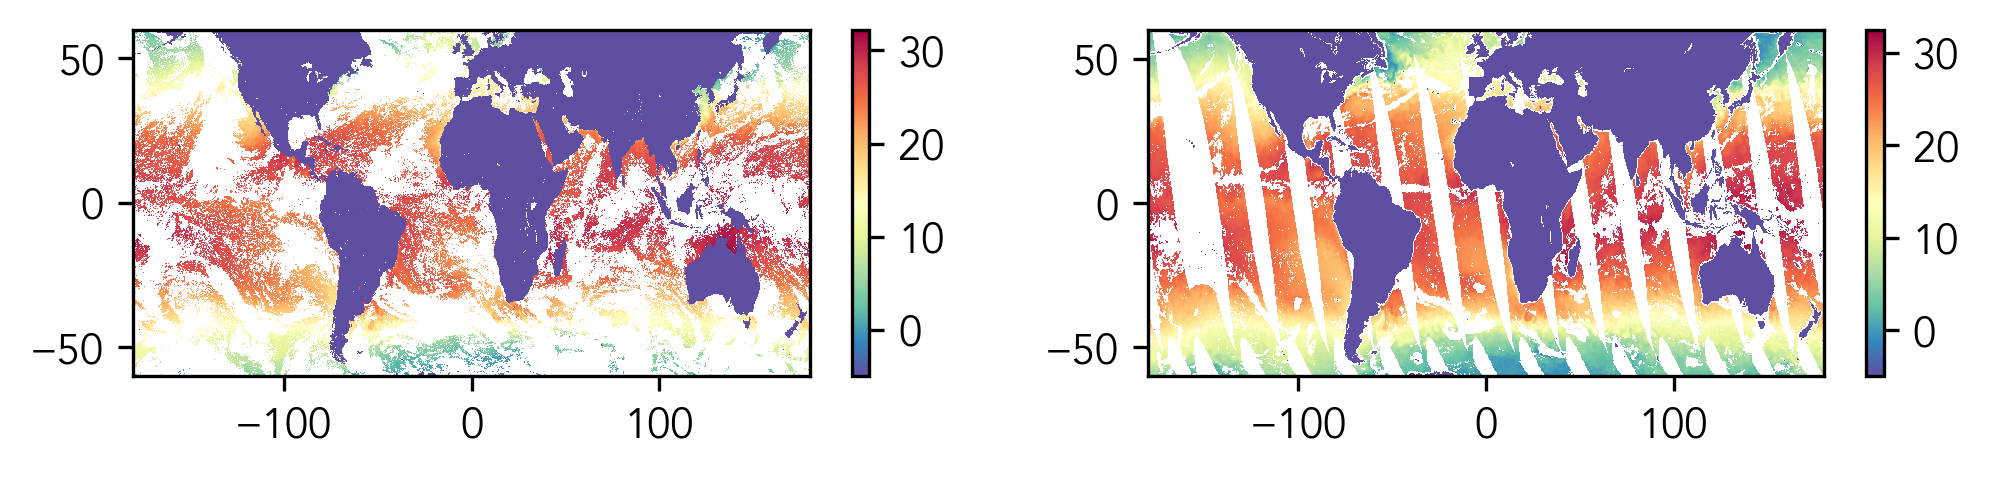

In [ ]:
date = '20140101'

path = os.path.join('~/data/L3S_PM', get_l3s_fname(date))
ir_ds = open_ds(path)

path = os.path.join('~/data/AMSR2', get_amsr_fname(date))
mw_ds = open_ds(path)
# path = os.path.join('~/data/L3S_PM', get_l3s_fname(date))

plt.figure(figsize=(8, 1.5), dpi=150)
plt.subplot(121)
plt.pcolormesh(ir_ds.lon[::10], ir_ds.lat[::10], ir_ds.sst[::10, ::10], cmap='Spectral_r')
plt.colorbar()

plt.subplot(122)
plt.pcolormesh(mw_ds.lon, mw_ds.lat, mw_ds.sst, cmap='Spectral_r')
plt.colorbar()

In [101]:
def datetime_obj(d):
    return datetime.strptime(d, '%Y%m%d')


def coord_in_bounds(lat, lon, date, bounds):
    return (
        (date >= bounds['date'][0]) and (date <= bounds['date'][1]),
        (lat >= bounds['lat'][0]) and (lat < bounds['lat'][1])
            and (lon >= bounds['lon'][0]) and (lon < bounds['lon'][1])
    )


def tile_label(lat, lon, date, val_bounds, test_bounds):
    val_date, val_loc = coord_in_bounds(lat, lon, date, val_bounds)
    test_date, test_loc = coord_in_bounds(lat, lon, date, test_bounds)

    if val_date and val_loc:
        label = 'val'
    elif test_date and test_loc:
        label = 'test'
    elif not val_date and not val_loc and not test_date and not test_loc:
        label = 'train'
    else:
        label = None
    return label

In [ ]:
def save_tiles_from_global_sst(date, window, stride, save_dir, val_bounds, test_bounds, mode='sst'):
    dataset = []
    ir_ds = open_ds(os.path.join('~/data/L3S_PM', get_l3s_fname(date)))
    mw_ds = open_ds(os.path.join('~/data/AMSR2', get_amsr_fname(date)))

    for lat in tqdm(range(0, len(mw_ds.lat) - window, stride)):
        for lon in range(0, len(mw_ds.lon) - window, stride):
            mw_tile = mw_ds.isel(lat=slice(lat, lat + window), lon=slice(lon, lon + window))
            coord_slice = dict(
                lat=slice(mw_tile.lat[0], mw_tile.lat[-1]),
                lon=slice(mw_tile.lon[0], mw_tile.lon[-1]),
            )
            label = tile_label(mw_tile.lat[0], mw_tile.lon[0], date, val_bounds, test_bounds)
            if label is None:
                continue
            ir_tile = ir_ds.sel(coord_slice)
            tile_name = f'{date.strftime("%Y%m%d")}_{mw_tile.lat[0]:.3f}_{mw_tile.lon[0]:.3f}'

            if (ir_tile.sst == -5).mean() > 0:
                # Ignoring all tiles with land for now
                continue

            if mode == 'sst':
                mw_rc = mw_tile.sst.isnull().mean()
                if mw_rc > 0:
                    continue
                ir_rc = ir_tile.sst.isnull().mean()
                if ir_rc > 0.005:
                    continue
                # Some stupid netCDF encoding issue
                ir_tile.attrs['collation_input'] = str(ir_tile.attrs['collation_input'])

            elif mode == 'cloud':
                ir_cloud = ir_tile.sst.isnull()
                ir_cloud_sim = ir_cloud | ir_cloud[::-1]
                ir_rc = ir_cloud.mean()
                ir_sim_rc = ir_cloud_sim.mean()
                if (ir_rc < 0.1) or (ir_rc > 0.8) or (ir_sim_rc > 0.9):
                    # Check if augmented cloud mask is completely cloudy
                    continue
                mw_cloud = mw_tile.sst.isnull().astype(float).interp_like(ir_cloud) > 0
                mw_ir_overlap = (~mw_cloud & ir_cloud).mean()
                if mw_ir_overlap < 0.5:
                    # IR cloudy and MW not cloudy
                    continue
                ir_tile = ir_cloud
                mw_tile = mw_tile.sst.isnull()

            mw_tile.to_netcdf(os.path.join(save_dir, f'amsr2_{tile_name}.nc'))
            ir_tile.to_netcdf(os.path.join(save_dir, f'acspo_{tile_name}.nc'))
            dataset.append(
                (f'amsr2_{tile_name}.nc', f'acspo_{tile_name}.nc', label)
            )

    ir_ds.close()
    mw_ds.close()
    df = pd.DataFrame(dataset, columns=['mw', 'ir', 'split'])
    return df


In [ ]:
import shutil


stride = 10
window = 10
mode = 'cloud'
save_dir = f'/Users/ellin/data/{mode}'

# Clear any existing tiles
try:
    shutil.rmtree(save_dir)
except FileNotFoundError:
    pass
os.makedirs(save_dir)

dfs = []
dates = [datetime_obj('20140101') + timedelta(days=i) for i in range(6)]
val_bounds = dict(lat=(0, 45), lon=(-180, -20), date=(datetime_obj('20140103'), datetime_obj('20140104')))
test_bounds = dict(lat=(-60, -10), lon=(40, 180), date=(datetime_obj('20140101'), datetime_obj('20140102')))
for d in dates:
    df = save_tiles_from_global_sst(d, window, stride, save_dir, val_bounds, test_bounds, mode=mode)
    dfs.append(df)
df = pd.concat(dfs)
print(f'Total tiles: {len(df)}')
for label in ['train', 'val', 'test']:
    n_label = (df['split'] == label).sum()
    print(f'{label} tiles: {n_label} ({n_label / len(df):.3f})')
df.to_csv(os.path.join(save_dir, 'split.csv'))

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Total tiles: 12
train tiles: 9 (0.750)
val tiles: 2 (0.167)
test tiles: 1 (0.083)


In [100]:
5128 / 64

80.125

## Initial model testing

In [2]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, in_ch=2, n_class=1):
        super().__init__()
                
        self.dconv_down1 = double_conv(in_ch, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import RandomVerticalFlip, Resize
# torchvision.transforms.v2.functional.vertical_flip

def scale(x):
    return (x + 0.5897) / (30.396 + 0.5897) - 0.5

def unscale(x):
    return (x + 0.5) * (30.396 + 0.5897) - 0.5897

class SSTDataset(Dataset):
    def __init__(self, data_dir, split, transform=None):
        self.data_dir = data_dir
        df = pd.read_csv(os.path.join(data_dir, 'split.csv'))
        df = df[df['split'] == split]
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, i):
        row = self.df.iloc[i]
        mw_ds = xr.open_dataset(os.path.join(self.data_dir, row['mw']))
        ir_ds = xr.open_dataset(os.path.join(self.data_dir, row['ir']))
        mw_ds = mw_ds.interp_like(ir_ds)
        ir = torch.from_numpy(ir_ds.sst.values)
        mw = torch.from_numpy(mw_ds.sst.values)
        cloud_mask = torch.isnan(ir)
        sim_cloud_mask = RandomVerticalFlip(p=1)(cloud_mask)
        ir_sim_clouds = torch.where(sim_cloud_mask, np.nan, ir)
        ir_sim_clouds = torch.where(~torch.isnan(mw) & torch.isnan(ir_sim_clouds), mw, ir_sim_clouds)
        if self.transform:
            pass
        # 'mw_input': torch.nan_to_num(scale(mw)), 
        data = {'ir_gt': scale(ir), 'ir_input': torch.nan_to_num(scale(ir_sim_clouds))}
        data = {k: Resize((112, 112))(v.unsqueeze(0)) for k, v in data.items()}
        return data
        # loss function: (ir_est - ir)

/Users/ellin/miniconda3/envs/py3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ellin/miniconda3/envs/py3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: <BE0CCD9A-269A-30E2-A23C-DA45E89EBB1F> /Users/ellin/miniconda3/envs/py3/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/ellin/miniconda3/envs/py3/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Users/ellin/miniconda3/envs/py3/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Users/ellin/miniconda3/envs/py3/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/Users/ellin/miniconda3/envs/py3/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file, not in dyld cache)
  warn(f"Failed to load image Pytho

In [52]:
vmax = -np.inf
vmin = np.inf
for data in tqdm(dataloader):
    break
    vmax = max(vmax, torch.max(data['ir_input']))
    vmin = min(vmin, torch.min(data['ir_input']))

  0%|          | 0/542 [00:00<?, ?it/s]

In [4]:
train_dataset = SSTDataset('/Users/ellin/data/tiles', 'train')
dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

val_dataset = SSTDataset('/Users/ellin/data/tiles', 'val')
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0)

def mask_mae(gt, est):
    known_mask = (~torch.isnan(gt)).float()
    return (torch.abs(torch.nan_to_num(gt) - est) * known_mask).sum() / known_mask.sum()

def test_loop(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            pred = model(data['ir_input'])
            loss = loss_fn(data['ir_gt'], pred)
            test_loss += loss.item()
            if i == 4:
                break

    test_loss /= i
    return test_loss

model = UNet(in_ch=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = mask_mae


In [6]:
len(dataloader)

136

In [5]:
for epoch in range(1):
    print(epoch, '--------------------------')
    for batch, data in enumerate(dataloader):
        model.train()
        # Compute prediction and loss
        pred = model(data['ir_input'])
        loss = loss_fn(data['ir_gt'], pred)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 4 == 0:
            print(f"{batch} loss: {loss.item():>7f}")
            # val_loss = test_loop(val_dataloader, model, loss_fn)
            # print(f"{batch} loss: {val_loss:>7f}")
        if batch == 30:
            break

0 --------------------------
0 loss: 0.351344
4 loss: 0.142574
8 loss: 0.133409
12 loss: 0.157809
16 loss: 0.076938
20 loss: 0.077592
24 loss: 0.134454
28 loss: 0.114321


In [8]:
data = val_dataset[0]
data['ir_gt'].shape

torch.Size([1, 112, 112])

In [29]:
model.eval()
with torch.no_grad():
    data = val_dataset[50]
    pred = model(data['ir_input'].unsqueeze(0))
    loss = loss_fn(data['ir_gt'], pred)
    pred = pred.squeeze(0).squeeze(0).numpy()
    gt = data['ir_gt'].squeeze(0).numpy()
    input = data['ir_input'].squeeze(0).numpy()

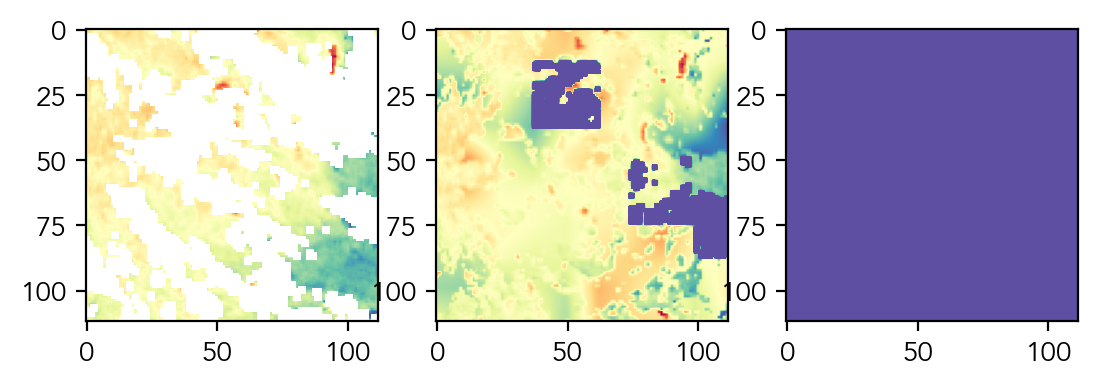

In [30]:
plt.subplot(131)
gt = unscale(gt)
plt.imshow(gt, cmap='Spectral_r', vmin=np.nanmin(gt), vmax=np.nanmax(gt))
plt.subplot(132)
plt.imshow(unscale(input), cmap='Spectral_r', vmin=np.nanmin(gt), vmax=np.nanmax(gt))
plt.subplot(133)
plt.imshow(unscale(pred), cmap='Spectral_r', vmin=np.nanmin(gt), vmax=np.nanmax(gt))

In [139]:
ir = ir_tile.sst.values
ir = torch.from_numpy(ir)
ir = torch.nan_to_num(ir)
ir = ir[:-1, :-1].unsqueeze(0).unsqueeze(0)

In [140]:
out = model(ir)

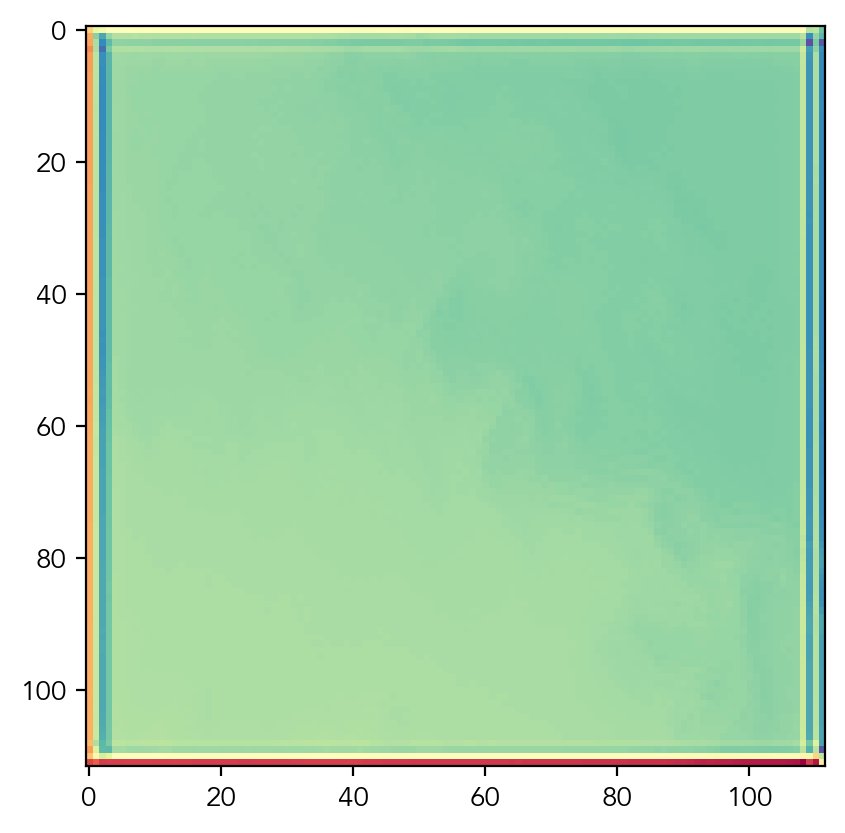

In [141]:
plt.imshow(out[0, 0].detach(), cmap='Spectral_r')

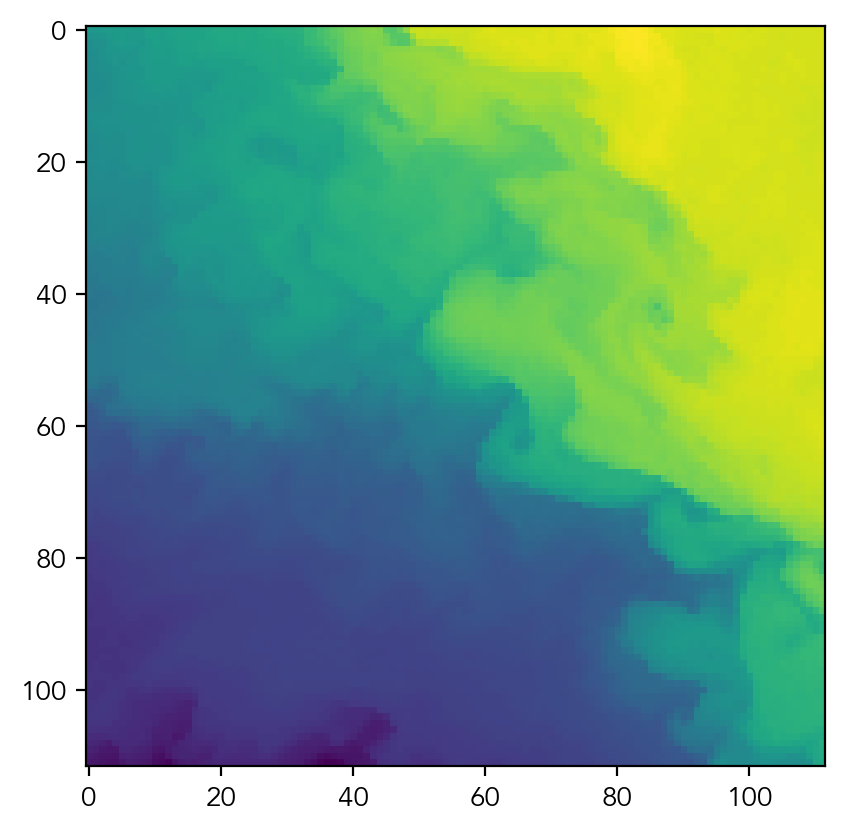

In [142]:
plt.imshow(ir[0, 0])